In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import trange, tqdm

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

from pandas import read_csv
from scipy import stats

In [2]:
name = 'LD2011_2014.txt'
save_name = 'elect'
num_covariates = 3
train_start = '2011-01-01 00:00:00'
train_end = '2014-08-31 23:00:00'
test_start = '2014-08-24 00:00:00' #need additional 7 days as given info
test_end = '2014-09-07 23:00:00'

save_path = os.path.join('data', save_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)
csv_path = os.path.join(save_path, name)
if not os.path.exists(csv_path):
    zipurl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip'
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(save_path)

In [10]:
target_df = pd.read_csv(csv_path, sep=";", index_col=0, parse_dates=True, decimal=',')
target_df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# initial fixing
# text_target_df的时序长度就是预测长度，即horizon_size;
target_df = pd.read_csv(csv_path, sep=";", index_col=0, parse_dates=True, decimal=',')
target_df = target_df.resample('12H',label = 'left',closed = 'right').sum()[train_start:test_end]
target_df.fillna(0, inplace=True)

train_target_df = target_df[train_start:train_end]
test_target_df = target_df[test_start:test_end]
horizon_size = test_target_df.shape[0]

In [4]:
target_df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# 归一化目标值
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_target_df)
train_target_df = pd.DataFrame(scaler.transform(train_target_df), index=train_target_df.index, columns=train_target_df.columns)
test_target_df = pd.DataFrame(scaler.transform(test_target_df), index=test_target_df.index, columns=test_target_df.columns)

In [6]:
# 提取小时、天、月份作为特征
covariate_df = pd.DataFrame(index=target_df.index,
                                data={'hour':target_df.index.hour,
                                      'dayofweek':target_df.index.dayofweek,
                                      'month': target_df.index.month
                                })
display(covariate_df.head())
# 特征标准化
for col in covariate_df.columns:
        covariate_df[col] = (covariate_df[col] - np.mean(covariate_df[col]))/np.std(covariate_df[col])

train_covariate_df = covariate_df[train_start:train_end]
test_covariate_df = covariate_df[test_start:test_end]

,hour,dayofweek,month
2011-01-01 00:00:00,0,5,1
2011-01-01 12:00:00,12,5,1
2011-01-02 00:00:00,0,6,1
2011-01-02 12:00:00,12,6,1
2011-01-03 00:00:00,0,0,1


In [7]:
covariate_df.head()

,hour,dayofweek,month
2011-01-01 00:00:00,-1.0,0.997681,-1.541571
2011-01-01 12:00:00,1.0,0.997681,-1.541571
2011-01-02 00:00:00,-1.0,1.497450,-1.541571
2011-01-02 12:00:00,1.0,1.497450,-1.541571
2011-01-03 00:00:00,-1.0,-1.501163,-1.541571


In [19]:
import torch
from torch.utils.data import Dataset

desired_quantiles = [0.25, 0.5, 0.75, 0.95]

class MQRNN_dataset(Dataset):
    
    def __init__(self,
                series_df:pd.DataFrame,
                covariate_df:pd.DataFrame, 
                horizon_size:int=horizon_size,
                quantile_size:int=len(desired_quantiles)):
        
        self.series_df = series_df
        self.covariate_df = covariate_df
        self.horizon_size = horizon_size
        self.quantile_size = quantile_size
        full_covariate = []
        covariate_size = self.covariate_df.shape[1]
        # 按horizon_size为窗口长度，划分特征数据为horizon*
        for i in range(1, self.covariate_df.shape[0] - horizon_size+1):
            cur_covariate = []
            cur_covariate.append(self.covariate_df.iloc[i:i+horizon_size,:].to_numpy())
#             cur_covariate = self.covariate_df.iloc[i:i+horizon_size,:].to_numpy()
            full_covariate.append(cur_covariate)
        full_covariate = np.array(full_covariate)
        print(full_covariate.shape)
        full_covariate = full_covariate.reshape(-1, horizon_size * covariate_size)
        print(full_covariate.shape)
        self.next_covariate = full_covariate
    
    def __len__(self):
        return self.series_df.shape[1]
    
    def __getitem__(self, idx):
        cur_series = np.array(self.series_df.iloc[: -self.horizon_size, idx])
        cur_covariate = np.array(self.covariate_df.iloc[:-self.horizon_size, :]) # covariate used in generating hidden states

        covariate_size = self.covariate_df.shape[1]

        # 真实值y，每组都是horizon_size的长度，这里时间序列就是1-30,2-31,3-32
        real_vals_list = []
        for i in range(1, self.horizon_size+1):
            real_vals_list.append(np.array(self.series_df.iloc[i: self.series_df.shape[0]-self.horizon_size+i, idx]))
        real_vals_array = np.array(real_vals_list) #[horizon_size, seq_len]
        real_vals_array = real_vals_array.T #[seq_len, horizon_size]
        
        cur_series_tensor = torch.tensor(cur_series)
        cur_series_tensor = torch.unsqueeze(cur_series_tensor,dim=1) # [seq_len, 1]
        cur_covariate_tensor = torch.tensor(cur_covariate) #[seq_len, covariate_size]
        # encoder的输入矩阵
        cur_series_covariate_tensor = torch.cat([cur_series_tensor, cur_covariate_tensor],dim=1)
        # decoder的输入矩阵
        next_covariate_tensor = torch.tensor(self.next_covariate) #[seq_len, horizon_size * covariate_size]
        # 真实值
        cur_real_vals_tensor = torch.tensor(real_vals_array)
        return cur_series_covariate_tensor, next_covariate_tensor, cur_real_vals_tensor

In [20]:
data.next_covariate.shape

(2648, 90)

In [21]:
data = MQRNN_dataset(train_target_df, train_covariate_df)
# data.__getitem__(10)[1].shape

(2648, 1, 30, 3)
(2648, 90)


In [135]:
from torch.utils.data import DataLoader
from tqdm import tqdm, trange

data_iter = DataLoader(dataset=data, batch_size=16, shuffle=True)
pbar = tqdm(data_iter)
for (cur_series_tensor, cur_covariate_tensor, cur_real_vals_tensor) in pbar:
    batch_size, seq_len, horizon_size  = cur_series_tensor.shape[0], cur_series_tensor.shape[1], cur_covariate_tensor.shape[-1]
    print(seq_len)

  8%|██████▉                                                                            | 2/24 [00:00<00:02,  8.00it/s]

2648
2648


 17%|█████████████▊                                                                     | 4/24 [00:00<00:02,  8.54it/s]

2648
2648
2648


 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:01,  9.54it/s]

2648
2648
2648


 46%|█████████████████████████████████████▌                                            | 11/24 [00:01<00:01, 10.10it/s]

2648
2648
2648


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:01<00:01,  9.73it/s]

2648
2648


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:01<00:00,  9.59it/s]

2648
2648
2648


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:01<00:00,  9.81it/s]

2648
2648


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:02<00:00,  9.42it/s]

2648
2648


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:02<00:00,  9.35it/s]

2648
2648


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.75it/s]

2648
2648


In [8]:
import torch
import torch.nn as nn

class MQRNN(nn.Module):
    def __init__(self, 
                horizon_size:int=horizon_size, 
                hidden_size:int=100, 
                quantiles:list=desired_quantiles,
                dropout:float=0.3,
                layer_size:int=3,
                context_size:int=50, 
                covariate_size:int=num_covariates,
                bidirectional=False,
                device=torch.device('cuda')):
        super(MQRNN, self).__init__()
        self.quantiles = desired_quantiles
        self.quantile_size = len(quantiles)
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.horizon_size = horizon_size
        self.device = device
        self.covariate_size = covariate_size

        self.encoder = nn.LSTM(input_size= covariate_size+1, 
                            hidden_size=hidden_size, 
                            num_layers=layer_size, 
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.global_decoder = nn.Sequential(nn.Linear(in_features= hidden_size + covariate_size*horizon_size, out_features= horizon_size*hidden_size*3),
                                           nn.ReLU(),
                                           nn.Linear(in_features= horizon_size*hidden_size*3, out_features= horizon_size*hidden_size*2),
                                           nn.ReLU(),
                                           nn.Linear(in_features= horizon_size*hidden_size*2, out_features= (horizon_size+1)*context_size),
                                           nn.ReLU())
        self.local_decoder = nn.Sequential(nn.Linear(in_features= horizon_size*context_size + horizon_size* covariate_size + context_size, out_features= horizon_size* context_size),
                                           nn.ReLU(),
                                           nn.Linear(in_features= horizon_size* context_size, out_features= horizon_size*self.quantile_size),
                                           nn.ReLU())
        self.encoder.double().to(self.device)
        self.global_decoder.double().to(self.device)
        self.local_decoder.double().to(self.device)
        
    def forward(self, cur_series_covariate_tensor, next_covariate_tensor):
        seq_len, batch_size = cur_series_covariate_tensor.shape[0], cur_series_covariate_tensor.shape[1]
        direction_size = 2 if self.bidirectional else 1
        outputs,_ = self.encoder(cur_series_covariate_tensor)
        outputs_reshape = outputs.view(seq_len,batch_size,direction_size,self.hidden_size)[:,:,-1,:]
        encoder_outputs = outputs_reshape.view(seq_len,batch_size,self.hidden_size)
        if not self.training:
            encoder_outputs = torch.unsqueeze(encoder_outputs[-1],dim=0) #[1,1,hidden_size]

        global_decoder_output = self.global_decoder(torch.cat([encoder_outputs, next_covariate_tensor], dim=2))
        local_decoder_output = self.local_decoder(torch.cat([global_decoder_output, next_covariate_tensor], dim=2))
        
        seq_len = local_decoder_output.shape[0]
        batch_size = local_decoder_output.shape[1]
        return local_decoder_output.view(seq_len, batch_size, self.horizon_size, self.quantile_size)

In [9]:
from torch.utils.data import DataLoader
from tqdm import tqdm, trange

def train(model, train_dataset, desired_quantiles=desired_quantiles, batch_size=1, num_epochs=1, lr=1e-3, device=torch.device("cuda")):
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    data_iter = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for epoch in range(num_epochs):
        epoch_loss_sum = 0.0
        total_sample = 0
        pbar = tqdm(data_iter)
        for (cur_series_tensor, cur_covariate_tensor, cur_real_vals_tensor) in pbar:
            batch_size, seq_len, horizon_size  = cur_series_tensor.shape[0], cur_series_tensor.shape[1], cur_covariate_tensor.shape[-1]
            total_sample += batch_size * seq_len * horizon_size
            optimizer.zero_grad()
            cur_series_covariate_tensor = cur_series_tensor.double().permute(1,0,2).to(device) #[seq_len, batch_size, 1+covariate_size]
            next_covariate_tensor = cur_covariate_tensor.double().permute(1,0,2).to(device) #[seq_len, batch_size, covariate_size * horizon_size]
            cur_real_vals_tensor = cur_real_vals_tensor.double().permute(1,0,2).to(device) #[seq_len, batch_size, horizon_size]
            print(cur_series_covariate_tensor.shape, next_covariate_tensor.shape)
            model_output = model(cur_series_covariate_tensor, next_covariate_tensor)
            print(model_output.shape)
            losses = []
            for i, p in enumerate(desired_quantiles):
                errors = cur_real_vals_tensor - model_output[:,:,:,i]
                losses.append(torch.max((p-1)*errors, p*errors))
            total_loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1)).to(device)
            
#             total_loss = torch.tensor([0.0]).to(device)
#             for i in range(len(desired_quantiles)):
#                 p = desired_quantiles[i]
#                 errors = cur_real_vals_tensor - model_output[:,:,:,i]
#                 cur_loss = torch.max((p-1)*errors, p*errors)
#                 total_loss += torch.sum(cur_loss)

            pbar.set_description(f"Loss:{total_loss.item()}")
            total_loss.backward()
            optimizer.step()
            epoch_loss_sum += total_loss.item()
        epoch_loss_mean = epoch_loss_sum/ total_sample
        if (epoch+1)%5 == 0:
            print(f"epoch_num {epoch+1}, current loss is: {epoch_loss_mean}")

def evaluate(model, device=torch.device('cuda'), covariate_size=3):
    full_covariate_tensor = torch.tensor(train_covariate_df.to_numpy()).to(device)
    next_covariate_tensor = torch.tensor(test_covariate_df.to_numpy().reshape(-1, horizon_size * covariate_size)).unsqueeze(dim=0).to(device)#[1,1,horizon_size * covariate_size]
    results = []

    model.eval()
    with torch.no_grad():
        for colname in tqdm(train_target_df.columns):
            input_target_tensor = torch.tensor(train_target_df[[colname]].to_numpy()).to(device)
            input_target_covariate_tensor = torch.unsqueeze(torch.cat([input_target_tensor, full_covariate_tensor], dim=1), dim= 0).to(device) #[1, seq_len, 1+covariate_size]
            input_target_covariate_tensor = input_target_covariate_tensor.permute(1,0,2).to(device) #[seq_len, 1, 1+covariate_size]
            model_output = model(input_target_covariate_tensor, next_covariate_tensor)
            
            output_array = model_output.squeeze(0).cpu()
            results.append(output_array)
    # 预测结果，结构为 [时间序列数, horizon_size, quantile
    predictions = torch.cat(results)
    diff = torch.sum(torch.mul(predictions[:,:,1].T - torch.tensor(test_target_df.to_numpy()), predictions[:,:,1].T - torch.tensor(test_target_df.to_numpy()))).item()
    test_rmse = np.sqrt(diff/test_target_df.shape[1])
    return test_rmse

In [12]:
device=torch.device("cuda")
horizon_size = 30
full_covariate_tensor = torch.tensor(train_covariate_df.to_numpy()).to(device)
next_covariate_tensor = torch.tensor(test_covariate_df.to_numpy().reshape(-1, horizon_size * covariate_size)).unsqueeze(dim=0).to(device)#[1,1,horizon_size * covariate_size]
results = []
print(full_covariate_tensor.shape, next_covariate_tensor.shape)
# model.eval()
# with torch.no_grad():
for colname in tqdm(train_target_df.columns):
    input_target_tensor = torch.tensor(train_target_df[[colname]].to_numpy()).to(device)
    input_target_covariate_tensor = torch.unsqueeze(torch.cat([input_target_tensor, full_covariate_tensor], dim=1), dim= 0).to(device) #[1, seq_len, 1+covariate_size]
    input_target_covariate_tensor = input_target_covariate_tensor.permute(1,0,2).to(device) #[seq_len, 1, 1+covariate_size]
    print(input_target_covariate_tensor.shape)
    print(next_covariate_tensor.shape)
#         model_output = model(input_target_covariate_tensor, next_covariate_tensor)

#         output_array = model_output.squeeze(0).cpu()
#         results.append(output_array)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
model = MQRNN()
train_dataset = MQRNN_dataset(train_target_df, train_covariate_df)
train(model, train_dataset, batch_size=16, num_epochs=1, lr=0.0001)
# test_rmse = evaluate(model)
# print(test_rmse)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

torch.Size([2648, 16, 4]) torch.Size([2648, 16, 90])
torch.Size([2648, 16, 30, 4])


Loss:12.562996042517938:   4%|██▎                                                    | 1/24 [02:59<1:08:54, 179.77s/it]

torch.Size([2648, 16, 4]) torch.Size([2648, 16, 90])
torch.Size([2648, 16, 30, 4])


Loss:13.565271254480793:   8%|████▌                                                  | 2/24 [06:49<1:16:42, 209.21s/it]

torch.Size([2648, 16, 4]) torch.Size([2648, 16, 90])
torch.Size([2648, 16, 30, 4])


Loss:13.208515757016654:  12%|██████▉                                                | 3/24 [10:47<1:17:51, 222.45s/it]

torch.Size([2648, 16, 4]) torch.Size([2648, 16, 90])
torch.Size([2648, 16, 30, 4])


Loss:8.788618543396083:  12%|███████                                                 | 3/24 [12:04<1:24:28, 241.36s/it]


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

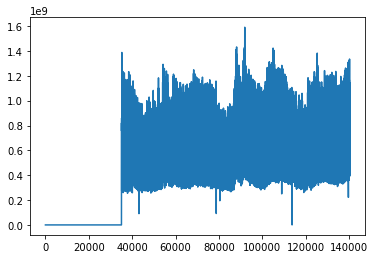

In [29]:
from matplotlib import pyplot as plt
plt.plot(scaler.inverse_transform(target_df)[:, 0:100].sum(axis=1))

In [32]:
?torch.cat

In [21]:
train_covariate_df.shape

(2678, 3)